In [6]:
import os
import librosa
import numpy as np
import pandas as pd
import parselmouth
from parselmouth.praat import call
from scipy.stats import entropy, kurtosis, skew
import gc

# Define paths to your datasets
input_folders = [
    r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadText\HC',
    r'E:\PC-GITA_per_task_44100Hz\PC-GITA_per_task_44100Hz\read text\ayerfuialmedico\sin normalizar\Cleaned_ReadText\PD'
]
labels = ['HC', 'PD']
csv_output_path = r'E:\Revision Dataset-2\enhanced_integral_feature_data2.csv'
segment_duration = 5  # Duration of each segment in seconds

# Function for noise reduction using spectral gating
def spectral_gating(y, sr, threshold_ratio=1.5, noise_len=0.5):
    noise_samples = int(noise_len * sr)
    noise_profile = y[:noise_samples]
    noise_spectrum = np.mean(np.abs(librosa.stft(noise_profile)), axis=1)

    stft_y = librosa.stft(y)
    stft_y_magnitude, stft_y_phase = np.abs(stft_y), np.angle(stft_y)
    spectral_threshold = noise_spectrum * threshold_ratio
    stft_y_denoised = np.where(stft_y_magnitude < spectral_threshold[:, None], 0, stft_y_magnitude)
    y_denoised = librosa.istft(stft_y_denoised * np.exp(1j * stft_y_phase))
    return y_denoised

# Function to extract features using librosa
def extract_librosa_features(y, sr):
    features = {}
    
    # MFCC and its delta features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_delta = librosa.feature.delta(mfcc)  # First derivative
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)  # Second derivative
    
    # Store each MFCC coefficient and its delta as separate features
    for i in range(mfcc.shape[0]):
        features[f'mfcc_{i+1}'] = mfcc[i].mean()
        features[f'mfcc_delta_{i+1}'] = mfcc_delta[i].mean()
        features[f'mfcc_delta2_{i+1}'] = mfcc_delta2[i].mean()
    
    # Extract other features
    features['mel_spectrogram'] = np.mean(librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128))
    features['chroma_stft'] = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
    features['rmse'] = np.mean(librosa.feature.rms(y=y))
    features['spectral_contrast'] = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr))
    features['spectral_flatness'] = np.mean(librosa.feature.spectral_flatness(y=y))
    features['spectral_centroid'] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    features['spectral_bandwidth'] = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    features['spectral_rolloff'] = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    features['zcr'] = np.mean(librosa.feature.zero_crossing_rate(y))
    
    return features

# Extract formants and other features from the voice sample using Praat
def extract_praat_features(file_path):
    sound = parselmouth.Sound(file_path)
    point_process = call(sound, "To PointProcess (periodic, cc)", 75, 500)
    
    features = {
        'jitter_local': call(point_process, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3),
        'shimmer_local': call([sound, point_process], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6),
        'f0_mean': call(sound.to_pitch(), "Get mean", 0, 0, "Hertz"),
        'hnr': call(sound.to_harmonicity(), "Get mean", 0, 0)
    }
    return features

# Function to extract statistical features
def extract_statistical_features(y):
    energy = np.abs(librosa.feature.rms(y=y))
    return {
        'entropy': entropy(energy.flatten()),
        'kurtosis': kurtosis(energy.flatten()),
        'skewness': skew(energy.flatten())
    }

# Function to extract all features from a .wav file
def extract_features(file_path, label, file_name):
    y, sr = librosa.load(file_path, sr=None)
    y = spectral_gating(y, sr)  # Apply noise reduction
    segment_samples = segment_duration * sr
    num_segments = len(y) // segment_samples
    all_features = []
    
    for i in range(num_segments):
        start = i * segment_samples
        end = start + segment_samples
        y_segment = y[start:end]
        
        # Extract all features
        librosa_features = extract_librosa_features(y_segment, sr)
        praat_features = extract_praat_features(file_path)
        statistical_features = extract_statistical_features(y_segment)
        
        # Combine all features into a single dictionary
        segment_features = {**librosa_features, **praat_features, **statistical_features}
        segment_features['label'] = label
        segment_features['file_name'] = file_name
        segment_features['segment'] = i + 1
        all_features.append(segment_features)
        
    return all_features

# Function to process all files in a folder and assign label (0 for HC, 1 for PD)
def process_folder(folder_path, label):
    folder_features = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.wav'):
            file_path = os.path.join(folder_path, file_name)
            file_features = extract_features(file_path, label, file_name)
            folder_features.extend(file_features)
    return folder_features

# Extract features from both HC and PD folders
all_features = []
for folder, label in zip(input_folders, [0, 1]):
    folder_features = process_folder(folder, label)
    all_features.extend(folder_features)

# Save features to a CSV file
combined_features = pd.DataFrame(all_features)
combined_features.to_csv(csv_output_path, index=False)
print(f"Features extracted and saved to {csv_output_path}")


Features extracted and saved to E:\Revision Dataset-2\enhanced_integral_feature_data2.csv


In [3]:
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedGroupKFold, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc
)
from scipy.stats import randint
import plotly.express as px
import plotly.graph_objects as go
import time

# Load the CSV file
csv_path = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\SpontaneousDialogue\enhanced_integral_feature_dataset-ii.csv'
data = pd.read_csv(csv_path)

# Extract relevant columns
labels = data['label'].values  # Labels (0 for HC, 1 for PD)
file_names = data['file_name'].values  # File names (e.g., ID00_hc_0_0_0.wav)
features = data.iloc[:, :-3].values  # All feature columns (excluding label, file_name, segment)

# Extract patient ID from file_name
def extract_patient_id(file_name):
    return file_name.split('_')[0]  # Extract the patient ID (e.g., ID00)

groups = np.array([extract_patient_id(file_name) for file_name in file_names])  # Groups (patient IDs)

# Analyze dataset
def analyze_dataset(labels, groups):
    # Count samples for each class
    hc_samples = np.sum(labels == 0)
    pd_samples = np.sum(labels == 1)
    
    # Count unique patients for each class
    hc_patients = np.unique(groups[labels == 0])
    pd_patients = np.unique(groups[labels == 1])
    
    # Print results
    print(f"Total HC samples: {hc_samples}")
    print(f"Total PD samples: {pd_samples}")
    print(f"Total samples: {len(labels)}")
    print(f"Unique HC patients: {len(hc_patients)}")
    print(f"Unique PD patients: {len(pd_patients)}")
    print(f"Total unique patients: {len(np.unique(groups))}")
    
    # Print group names for each class
    print("\nHC Patient IDs:")
    print(hc_patients)
    print("\nPD Patient IDs:")
    print(pd_patients)

# Analyze the dataset
analyze_dataset(labels, groups)



Total HC samples: 557
Total PD samples: 406
Total samples: 963
Unique HC patients: 21
Unique PD patients: 15
Total unique patients: 36

HC Patient IDs:
['ID00' 'ID01' 'ID03' 'ID05' 'ID08' 'ID09' 'ID10' 'ID11' 'ID12' 'ID14'
 'ID15' 'ID19' 'ID21' 'ID22hc' 'ID23' 'ID25' 'ID26' 'ID28' 'ID31' 'ID35'
 'ID36']

PD Patient IDs:
['ID02' 'ID04' 'ID06' 'ID07' 'ID13' 'ID16' 'ID17' 'ID20' 'ID24' 'ID27'
 'ID29' 'ID30' 'ID32' 'ID33' 'ID34']


Selected Hyperparameters for MFCC:
Fold 1: {'bootstrap': False, 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 6, 'min_samples_split': 11, 'n_estimators': 53}
Fold 2: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 13, 'n_estimators': 63}
Fold 3: {'bootstrap': False, 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 150}
Fold 4: {'bootstrap': False, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 137}
Fold 5: {'bootstrap': True, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 17, 'n_estimators': 164}
Mean Training Time for MFCC: 45.9062 seconds
Mean Testing Time for MFCC: 0.0167 seconds


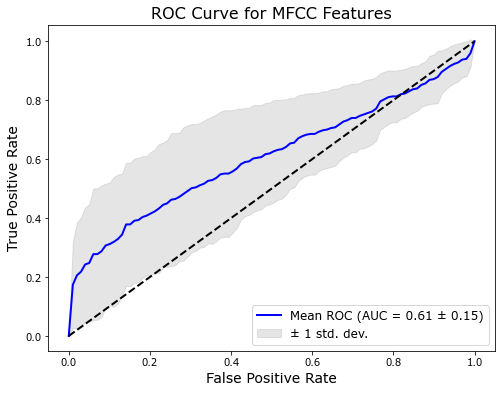

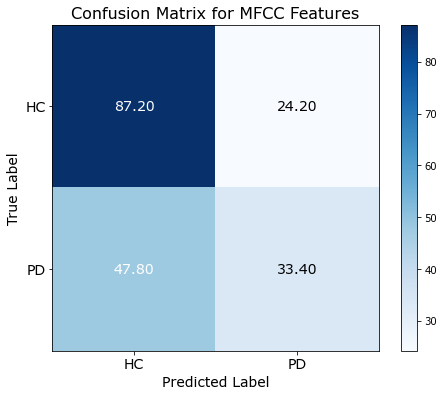

Selected Hyperparameters for Spectrogram:
Fold 1: {'bootstrap': True, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 9, 'min_samples_split': 14, 'n_estimators': 52}
Fold 2: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'min_samples_split': 13, 'n_estimators': 93}
Fold 3: {'bootstrap': True, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 16, 'n_estimators': 102}
Fold 4: {'bootstrap': True, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 12, 'n_estimators': 91}
Fold 5: {'bootstrap': False, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 100}
Mean Training Time for Spectrogram: 22.6135 seconds
Mean Testing Time for Spectrogram: 0.0128 seconds


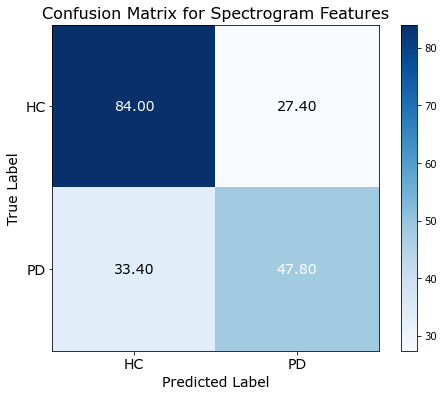

Selected Hyperparameters for Spectral:
Fold 1: {'bootstrap': True, 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 196}
Fold 2: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 191}
Fold 3: {'bootstrap': False, 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 150}
Fold 4: {'bootstrap': True, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 73}
Fold 5: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 191}
Mean Training Time for Spectral: 30.0345 seconds
Mean Testing Time for Spectral: 0.0204 seconds


Selected Hyperparameters for Voice_Quality:
Fold 1: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 191}
Fold 2: {'bootstrap': False, 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 6, 'min_samples_split': 11, 'n_estimators': 53}
Fold 3: {'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 13, 'n_estimators': 88}
Fold 4: {'bootstrap': False, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 137}
Fold 5: {'bootstrap': False, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 137}
Mean Training Time for Voice_Quality: 15.7320 seconds
Mean Testing Time for Voice_Quality: 0.0184 seconds


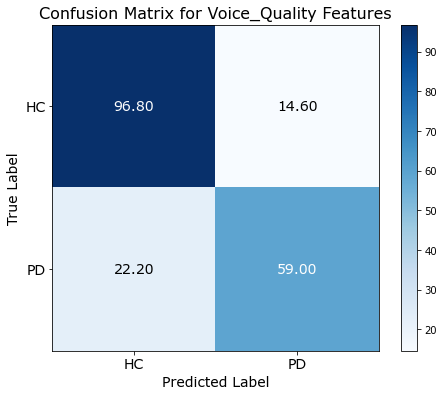

Selected Hyperparameters for All_Features:
Fold 1: {'bootstrap': True, 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 6, 'min_samples_split': 12, 'n_estimators': 193}
Fold 2: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 184}
Fold 3: {'bootstrap': True, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 99}
Fold 4: {'bootstrap': True, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 17, 'n_estimators': 164}
Fold 5: {'bootstrap': True, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 16, 'n_estimators': 102}
Mean Training Time for All_Features: 49.2915 seconds
Mean Testing Time for All_Features: 0.0227 seconds


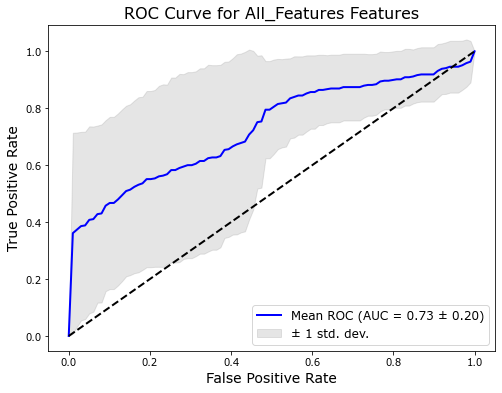

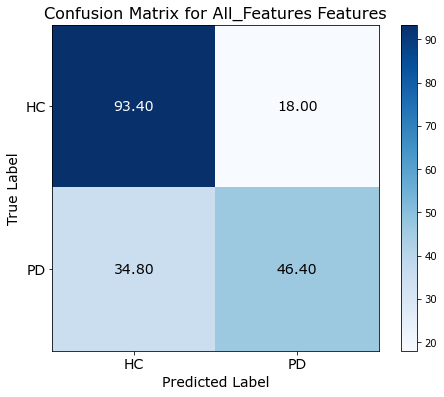

     Feature Set  Mean accuracy  Mean precision  Mean recall   Mean f1  \
0           MFCC       0.627296        0.569411     0.411708  0.476473   
1    Spectrogram       0.683892        0.640272     0.587643  0.606794   
2       Spectral       0.648404        0.614527     0.483261  0.536300   
3  Voice_Quality       0.805236        0.841651     0.726301  0.748577   
4   All_Features       0.722990        0.736828     0.569059  0.620170   

   Mean roc_auc  Mean mcc  Mean log_loss  Mean cohen_kappa  Mean mae  ...  \
0      0.608734  0.206868       0.673166          0.202191  0.372704  ...   
1      0.744668  0.351564       0.611555          0.345831  0.316108  ...   
2      0.687574  0.268024       0.644549          0.259835  0.351596  ...   
3      0.796657  0.620379       0.814151          0.597054  0.194764  ...   
4      0.728347  0.432708       0.603811          0.414765  0.277010  ...   

   Std Dev f1  Std Dev roc_auc  Std Dev mcc  Std Dev log_loss  \
0    0.163025         0.149

In [4]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedGroupKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier  # Replace KNN with Random Forest
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, matthews_corrcoef, log_loss, cohen_kappa_score, mean_absolute_error, roc_curve
)
from scipy.stats import randint

# Load the CSV file with extracted features
csv_output_path = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\SpontaneousDialogue\enhanced_integral_feature_dataset-ii.csv'
data = pd.read_csv(csv_output_path)

# Remove any rows with null values
data.dropna(inplace=True)

# Extract patient ID from file_name
def extract_patient_id(file_name):
    return file_name.split('_')[0]  # Extract the patient ID (e.g., ID00)

# Add a 'group' column based on patient ID
data['group'] = data['file_name'].apply(extract_patient_id)

# Define feature groups based on feature types
feature_groups = {
    'MFCC': ['mfcc_1', 'mfcc_delta_1', 'mfcc_delta2_1', 'mfcc_2', 'mfcc_delta_2', 'mfcc_delta2_2', 
             'mfcc_3', 'mfcc_delta_3', 'mfcc_delta2_3', 'mfcc_4', 'mfcc_delta_4', 'mfcc_delta2_4', 
             'mfcc_5', 'mfcc_delta_5', 'mfcc_delta2_5', 'mfcc_6', 'mfcc_delta_6', 'mfcc_delta2_6', 
             'mfcc_7', 'mfcc_delta_7', 'mfcc_delta2_7', 'mfcc_8', 'mfcc_delta_8', 'mfcc_delta2_8', 
             'mfcc_9', 'mfcc_delta_9', 'mfcc_delta2_9', 'mfcc_10', 'mfcc_delta_10', 'mfcc_delta2_10', 
             'mfcc_11', 'mfcc_delta_11', 'mfcc_delta2_11', 'mfcc_12', 'mfcc_delta_12', 'mfcc_delta2_12', 
             'mfcc_13', 'mfcc_delta_13', 'mfcc_delta2_13', 'entropy', 'kurtosis', 'skewness'],
    'Spectrogram': ['mel_spectrogram', 'chroma_stft', 'entropy', 'kurtosis', 'skewness'],
    'Spectral': ['rmse', 'spectral_contrast', 'spectral_flatness', 'spectral_centroid', 
                 'spectral_bandwidth', 'spectral_rolloff', 'zcr', 'entropy', 'kurtosis', 'skewness'],
    'Voice_Quality': ['jitter_local', 'shimmer_local', 'f0_mean', 'hnr', 'entropy', 'kurtosis', 'skewness']
}

# Add a new feature group that combines all features
feature_groups['All_Features'] = list(set().union(*[features for features in feature_groups.values()]))

# Parameter grid for RandomizedSearchCV (Random Forest)
param_dist = {
    'n_estimators': randint(50, 200),  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': randint(2, 20),  # Minimum samples required to split a node
    'min_samples_leaf': randint(1, 10),  # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2'],  # Number of features to consider at each split
    'bootstrap': [True, False],  # Whether to use bootstrap sampling
}

# Store results for comparison
results = []

# Loop through each feature group
for group_name, features in feature_groups.items():
    X = data[features]
    y = data['label']
    groups = data['group']
    
    # Initialize StratifiedGroupKFold
    sgkf = StratifiedGroupKFold(n_splits=5)
    
    # Store metrics for each fold
    fold_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'roc_auc': [],
        'mcc': [],
        'log_loss': [],
        'cohen_kappa': [],
        'mae': [],
        'specificity': [],
        'training_time': [],  # Store training time for each fold
        'testing_time': []   # Store testing time for each fold
    }
    
    # For ROC curve
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    # For confusion matrix
    conf_matrices = []
    
    # For storing selected hyperparameters
    selected_params = []
    
    # Perform cross-validation
    for fold, (train_idx, val_idx) in enumerate(sgkf.split(X, y, groups), 1):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Initialize the classifier with RandomizedSearchCV (Random Forest)
        clf = RandomForestClassifier(random_state=42)  # Use Random Forest
        random_search = RandomizedSearchCV(
            estimator=clf, param_distributions=param_dist, n_iter=50,
            scoring='accuracy', cv=5, verbose=0, random_state=42, n_jobs=-1
        )
        
        # Measure training time
        start_train_time = time.time()
        random_search.fit(X_train, y_train)
        end_train_time = time.time()
        training_time = end_train_time - start_train_time
        fold_metrics['training_time'].append(training_time)
        
        best_clf = random_search.best_estimator_
        
        # Store selected hyperparameters
        selected_params.append(random_search.best_params_)
        
        # Measure testing time
        start_test_time = time.time()
        y_pred = best_clf.predict(X_val)
        y_pred_proba = best_clf.predict_proba(X_val)[:, 1]
        end_test_time = time.time()
        testing_time = end_test_time - start_test_time
        fold_metrics['testing_time'].append(testing_time)
        
        # Calculate performance metrics
        fold_metrics['accuracy'].append(accuracy_score(y_val, y_pred))
        fold_metrics['precision'].append(precision_score(y_val, y_pred))
        fold_metrics['recall'].append(recall_score(y_val, y_pred))
        fold_metrics['f1'].append(f1_score(y_val, y_pred))
        fold_metrics['roc_auc'].append(roc_auc_score(y_val, y_pred_proba))
        fold_metrics['mcc'].append(matthews_corrcoef(y_val, y_pred))
        fold_metrics['log_loss'].append(log_loss(y_val, y_pred_proba))
        fold_metrics['cohen_kappa'].append(cohen_kappa_score(y_val, y_pred))
        fold_metrics['mae'].append(mean_absolute_error(y_val, y_pred))
        
        # Calculate specificity
        conf_matrix = confusion_matrix(y_val, y_pred)
        specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
        fold_metrics['specificity'].append(specificity)
        
        # Store confusion matrix
        conf_matrices.append(conf_matrix)
        
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        aucs.append(roc_auc_score(y_val, y_pred_proba))
    
    # Calculate mean and std dev of performance metrics
    mean_metrics = {k: np.mean(v) for k, v in fold_metrics.items()}
    std_metrics = {k: np.std(v) for k, v in fold_metrics.items()}
    
    # Store results for this feature group
    results.append({
        'Feature Set': group_name,
        **{f'Mean {k}': v for k, v in mean_metrics.items()},
        **{f'Std Dev {k}': v for k, v in std_metrics.items()},
        'Selected Hyperparameters': selected_params  # Add selected hyperparameters
    })
    
    # Print selected hyperparameters for this feature group
    print(f"Selected Hyperparameters for {group_name}:")
    for fold, params in enumerate(selected_params, 1):
        print(f"Fold {fold}: {params}")
    
    # Print mean training and testing time
    print(f"Mean Training Time for {group_name}: {mean_metrics['training_time']:.4f} seconds")
    print(f"Mean Testing Time for {group_name}: {mean_metrics['testing_time']:.4f} seconds")
    
    # Plot mean ROC curve with std dev
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    
    plt.figure(figsize=(8, 6))
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)
    plt.fill_between(mean_fpr, mean_tpr - np.std(tprs, axis=0), mean_tpr + np.std(tprs, axis=0), color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title(f'ROC Curve for {group_name} Features', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    
    # Plot mean confusion matrix with values
    mean_conf_matrix = np.mean(conf_matrices, axis=0)
    plt.figure(figsize=(8, 6))
    plt.imshow(mean_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {group_name} Features', fontsize=16)
    plt.colorbar()
    plt.xticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.yticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)

    # Add text annotations for the confusion matrix values
    thresh = mean_conf_matrix.max() / 2.  # Threshold for text color
    for i in range(mean_conf_matrix.shape[0]):
        for j in range(mean_conf_matrix.shape[1]):
            plt.text(j, i, f"{mean_conf_matrix[i, j]:.2f}",
                     horizontalalignment="center",
                     verticalalignment="center",
                     color="white" if mean_conf_matrix[i, j] > thresh else "black",
                     fontsize=14)

    plt.show()

# Convert results to DataFrame for easier comparison
results_df = pd.DataFrame(results)
print(results_df)

# Optionally, save the results to a CSV file
results_df.to_csv('d2feature_comparison_results_with_DII_rf.csv', index=False)

In [5]:
import pandas as pd

# Define the path to the CSV file
csv_output_path = r'd2feature_comparison_results_with_DII_rf.csv'

# Load the data
data = pd.read_csv(csv_output_path)

data

Feature Set  Mean accuracy  Mean precision  Mean recall   Mean f1  \
0           MFCC       0.627296        0.569411     0.411708  0.476473   
1    Spectrogram       0.683892        0.640272     0.587643  0.606794   
2       Spectral       0.648404        0.614527     0.483261  0.536300   
3  Voice_Quality       0.805236        0.841651     0.726301  0.748577   
4   All_Features       0.722990        0.736828     0.569059  0.620170   

   Mean roc_auc  Mean mcc  Mean log_loss  Mean cohen_kappa  Mean mae  ...  \
0      0.608734  0.206868       0.673166          0.202191  0.372704  ...   
1      0.744668  0.351564       0.611555          0.345831  0.316108  ...   
2      0.687574  0.268024       0.644549          0.259835  0.351596  ...   
3      0.796657  0.620379       0.814151          0.597054  0.194764  ...   
4      0.728347  0.432708       0.603811          0.414765  0.277010  ...   

   Std Dev f1  Std Dev roc_auc  Std Dev mcc  Std Dev log_loss  \
0    0.163025         0.149208     0.236756          0.100543   
1    0.049728         0.045626     0.058750          0.035896   
2    0.085249         0.064307     0.141702          0.063301   
3    0.195223         0.209277     0.291176          0.696468   
4    0.226737         0.201128     0.338352          0.170132   

   Std Dev cohen_kappa  Std Dev mae  Std Dev specificity  \
0             0.230284     0.105578             0.078353   
1             0.058499     0.025057             0.062884   
2             0.134861     0.065287             0.097775   
3             0.306636     0.150480             0.177935   
4             0.343960     0.164393             0.160545   

   Std Dev training_time  Std Dev testing_time  \
0               0.945073              0.006780   
1               0.276599              0.002299   
2               0.876673              0.004588   
3               1.632114              0.004758   
4               0.916506              0.004625   

                            Selected Hyperparameters  
0  [{'bootstrap': False, 'max_depth': 30, 'max_fe...  
1  [{'bootstrap': True, 'max_depth': 20, 'max_fea...  
2  [{'bootstrap': True, 'max_depth': 30, 'max_fea...  
3  [{'bootstrap': True, 'max_depth': 10, 'max_fea...  
4  [{'bootstrap': True, 'max_depth': 30, 'max_fea...  

[5 rows x 26 columns]

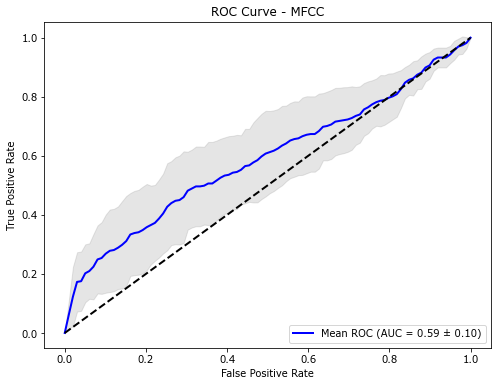

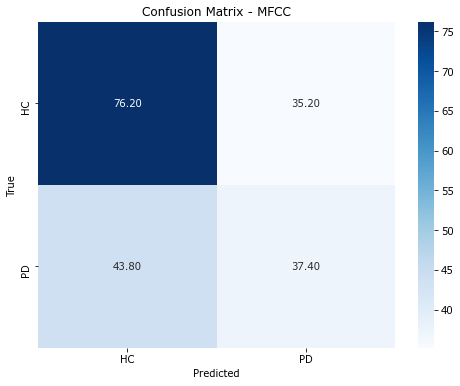

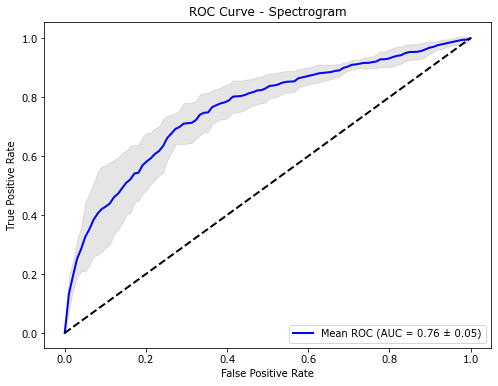

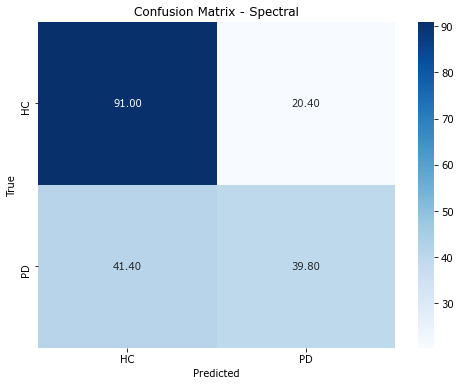

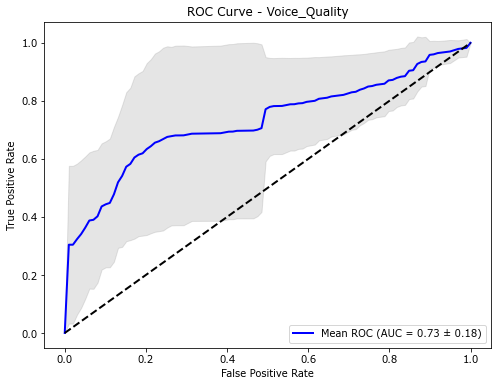

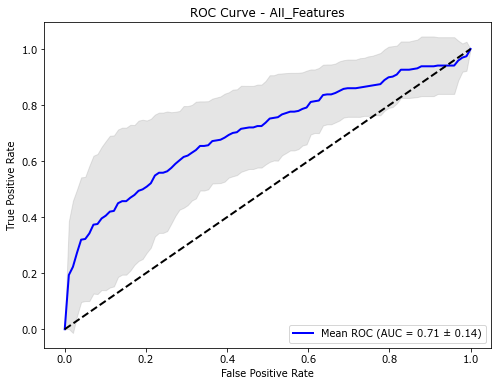

     Feature Set  Mean accuracy  Mean precision  Mean recall   Mean f1  \
0           MFCC       0.590835        0.507563     0.462020  0.480840   
1    Spectrogram       0.690770        0.672104     0.535653  0.587789   
2       Spectral       0.678168        0.702921     0.488774  0.560633   
3  Voice_Quality       0.674589        0.724428     0.532556  0.580043   
4   All_Features       0.659508        0.620960     0.530872  0.561456   

   Mean roc_auc  Mean mcc  Mean log_loss  Mean cohen_kappa  Mean mae  ...  \
0      0.588651  0.147785       0.683405          0.148340  0.409165  ...   
1      0.760279  0.359651       0.689334          0.348804  0.309230  ...   
2      0.738828  0.342730       0.681721          0.318200  0.321832  ...   
3      0.728586  0.358065       1.798252          0.326876  0.325411  ...   
4      0.705457  0.298240       0.652003          0.291031  0.340492  ...   

   Std Dev f1  Std Dev roc_auc  Std Dev mcc  Std Dev log_loss  \
0    0.122031         0.099

In [16]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedGroupKFold, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, matthews_corrcoef, log_loss, cohen_kappa_score, 
    mean_absolute_error, roc_curve
)
from scipy.stats import randint
import warnings
import seaborn as sns

# Suppress warnings
warnings.filterwarnings('ignore')

# Load and prepare data
def load_and_prepare_data(filepath):
    data = pd.read_csv(filepath)
    data.dropna(inplace=True)
    
    def extract_patient_id(file_name):
        if pd.isna(file_name):
            return "unknown"
        return file_name.split('_')[0]
    
    data['group'] = data['file_name'].apply(extract_patient_id)
    return data

# Feature group definitions
def get_feature_groups():
    feature_groups = {
        'MFCC': [f'mfcc_{i}' for i in range(1, 14)] + 
                [f'mfcc_delta_{i}' for i in range(1, 14)] +
                [f'mfcc_delta2_{i}' for i in range(1, 14)] +
                ['entropy', 'kurtosis', 'skewness'],
        'Spectrogram': ['mel_spectrogram', 'chroma_stft', 'entropy', 'kurtosis', 'skewness'],
        'Spectral': ['rmse', 'spectral_contrast', 'spectral_flatness', 'spectral_centroid',
                    'spectral_bandwidth', 'spectral_rolloff', 'zcr', 'entropy', 'kurtosis', 'skewness'],
        'Voice_Quality': ['jitter_local', 'shimmer_local', 'f0_mean', 'hnr', 'entropy', 'kurtosis', 'skewness']
    }
    feature_groups['All_Features'] = list(set().union(*feature_groups.values()))
    return feature_groups

# Parameter distribution for KNN
def get_parameter_dist():
    return {
        'n_neighbors': randint(1, 50),
        'weights': ['uniform', 'distance'],
        'p': [1, 2],
        'metric': ['euclidean', 'cosine']
    }

# Main evaluation function
def evaluate_feature_groups(data, feature_groups, param_dist, n_splits=5):
    results = []
    
    for group_name, features in feature_groups.items():
        X = data[features]
        y = data['label']
        groups = data['group']
        
        sgkf = StratifiedGroupKFold(n_splits=n_splits)
        
        fold_metrics = {
            'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': [],
            'mcc': [], 'log_loss': [], 'cohen_kappa': [], 'mae': [], 'specificity': [],
            'training_time': [], 'testing_time': []
        }
        
        tprs, aucs = [], []
        mean_fpr = np.linspace(0, 1, 100)
        conf_matrices = []
        selected_params = []
        
        for fold, (train_idx, val_idx) in enumerate(sgkf.split(X, y, groups), 1):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            try:
                # Feature scaling
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_val = scaler.transform(X_val)
                
                # Dimensionality reduction for high-dimensional groups
                if group_name in ['MFCC', 'All_Features']:
                    pca = PCA(n_components=0.95)
                    X_train = pca.fit_transform(X_train)
                    X_val = pca.transform(X_val)
                
                # Model training
                clf = KNeighborsClassifier()
                random_search = RandomizedSearchCV(
                    estimator=clf, param_distributions=param_dist, n_iter=10,
                    scoring='accuracy', cv=3, verbose=0, random_state=42, n_jobs=1
                )
                
                start_train = time.time()
                random_search.fit(X_train, y_train)
                training_time = time.time() - start_train
                
                best_clf = random_search.best_estimator_
                selected_params.append(random_search.best_params_)
                
                # Prediction and evaluation
                start_test = time.time()
                y_pred = best_clf.predict(X_val)
                
                # Check for degenerate predictions
                if len(np.unique(y_pred)) == 1:
                    raise ValueError(f"All predictions same: {y_pred[0]}")
                
                y_pred_proba = best_clf.predict_proba(X_val)
                if y_pred_proba.shape[1] != 2:
                    raise ValueError("predict_proba didn't return 2 columns")
                
                testing_time = time.time() - start_test
                
                # Calculate metrics
                metrics = {
                    'accuracy': accuracy_score(y_val, y_pred),
                    'precision': precision_score(y_val, y_pred, zero_division=np.nan),
                    'recall': recall_score(y_val, y_pred, zero_division=np.nan),
                    'f1': f1_score(y_val, y_pred, zero_division=np.nan),
                    'mcc': matthews_corrcoef(y_val, y_pred),
                    'log_loss': log_loss(y_val, y_pred_proba),
                    'cohen_kappa': cohen_kappa_score(y_val, y_pred),
                    'mae': mean_absolute_error(y_val, y_pred),
                    'training_time': training_time,
                    'testing_time': testing_time
                }
                
                # ROC AUC requires both classes
                if len(np.unique(y_val)) == 2:
                    metrics['roc_auc'] = roc_auc_score(y_val, y_pred_proba[:, 1])
                    fpr, tpr, _ = roc_curve(y_val, y_pred_proba[:, 1])
                    tprs.append(np.interp(mean_fpr, fpr, tpr))
                    tprs[-1][0] = 0.0
                    aucs.append(metrics['roc_auc'])
                else:
                    metrics['roc_auc'] = np.nan
                
                # Specificity calculation
                conf_matrix = confusion_matrix(y_val, y_pred)
                tn, fp, fn, tp = conf_matrix.ravel()
                metrics['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else np.nan
                conf_matrices.append(conf_matrix)
                
                # Store all metrics
                for k, v in metrics.items():
                    fold_metrics[k].append(v)
                    
            except Exception as e:
                print(f"Error in {group_name}, Fold {fold}: {str(e)}")
                for metric in fold_metrics:
                    fold_metrics[metric].append(np.nan)
                conf_matrices.append(np.array([[np.nan, np.nan], [np.nan, np.nan]]))
                selected_params.append({'n_neighbors': np.nan, 'weights': 'error', 'p': np.nan, 'metric': 'error'})
                continue
        
        # Calculate mean and std metrics
        mean_metrics = {k: np.nanmean(v) for k, v in fold_metrics.items()}
        std_metrics = {k: np.nanstd(v) for k, v in fold_metrics.items()}
        
        results.append({
            'Feature Set': group_name,
            **{f'Mean {k}': v for k, v in mean_metrics.items()},
            **{f'Std Dev {k}': v for k, v in std_metrics.items()},
            'Selected Hyperparameters': selected_params
        })
        
        # Visualization
        plot_results(group_name, mean_fpr, tprs, aucs, conf_matrices)
    
    return pd.DataFrame(results)

# Visualization functions
def plot_results(group_name, mean_fpr, tprs, aucs, conf_matrices):
    # ROC Curve
    if len(aucs) > 0 and not np.all(np.isnan(aucs)):
        mean_tpr = np.nanmean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = np.nanmean(aucs)
        std_auc = np.nanstd(aucs)
        
        plt.figure(figsize=(8, 6))
        plt.plot(mean_fpr, mean_tpr, color='b', 
                label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)
        plt.fill_between(mean_fpr, 
                        mean_tpr - np.nanstd(tprs, axis=0), 
                        mean_tpr + np.nanstd(tprs, axis=0), 
                        color='grey', alpha=0.2)
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {group_name}')
        plt.legend(loc="lower right")
        plt.show()
    
    # Confusion Matrix
    if len(conf_matrices) > 0 and not np.all(np.isnan(conf_matrices)):
        mean_conf_matrix = np.nanmean(conf_matrices, axis=0)
        plt.figure(figsize=(8, 6))
        sns.heatmap(mean_conf_matrix, annot=True, fmt='.2f', cmap='Blues',
                   xticklabels=['HC', 'PD'], yticklabels=['HC', 'PD'])
        plt.title(f'Confusion Matrix - {group_name}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

# Main execution
if __name__ == "__main__":
    # File path
    csv_path = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\SpontaneousDialogue\enhanced_integral_feature_dataset-ii.csv'
    
    # Load and prepare data
    data = load_and_prepare_data(csv_path)
    
    # Get feature groups and parameters
    feature_groups = get_feature_groups()
    param_dist = get_parameter_dist()
    
    # Run evaluation
    results_df = evaluate_feature_groups(data, feature_groups, param_dist)
    
    # Save and display results
    print(results_df)
    results_df.to_csv('d2feature_comparison_results_knn.csv', index=False)

In [18]:
import pandas as pd

# Define the path to the CSV file
csv_output_path = r'd2feature_comparison_results_knn.csv'

# Load the data
data = pd.read_csv(csv_output_path)

data

Feature Set  Mean accuracy  Mean precision  Mean recall   Mean f1  \
0           MFCC       0.590835        0.507563     0.462020  0.480840   
1    Spectrogram       0.690770        0.672104     0.535653  0.587789   
2       Spectral       0.678168        0.702921     0.488774  0.560633   
3  Voice_Quality       0.674589        0.724428     0.532556  0.580043   
4   All_Features       0.659508        0.620960     0.530872  0.561456   

   Mean roc_auc  Mean mcc  Mean log_loss  Mean cohen_kappa  Mean mae  ...  \
0      0.588651  0.147785       0.683405          0.148340  0.409165  ...   
1      0.760279  0.359651       0.689334          0.348804  0.309230  ...   
2      0.738828  0.342730       0.681721          0.318200  0.321832  ...   
3      0.728586  0.358065       1.798252          0.326876  0.325411  ...   
4      0.705457  0.298240       0.652003          0.291031  0.340492  ...   

   Std Dev f1  Std Dev roc_auc  Std Dev mcc  Std Dev log_loss  \
0    0.122031         0.099006     0.162795          0.052921   
1    0.069564         0.045105     0.073297          0.178812   
2    0.058155         0.086306     0.126846          0.145036   
3    0.068080         0.182365     0.187946          1.835254   
4    0.161821         0.139095     0.241330          0.155697   

   Std Dev cohen_kappa  Std Dev mae  Std Dev specificity  \
0             0.161119     0.072967             0.056595   
1             0.077426     0.033593             0.068589   
2             0.109956     0.058721             0.127739   
3             0.172448     0.101918             0.227558   
4             0.234016     0.111765             0.143651   

   Std Dev training_time  Std Dev testing_time  \
0               0.266977              0.043466   
1               0.138856              0.010691   
2               0.373097              0.014312   
3               0.096687              0.021274   
4               0.367842              0.040940   

                            Selected Hyperparameters  
0  [{'metric': 'cosine', 'n_neighbors': 36, 'p': ...  
1  [{'metric': 'euclidean', 'n_neighbors': 22, 'p...  
2  [{'metric': 'cosine', 'n_neighbors': 44, 'p': ...  
3  [{'metric': 'cosine', 'n_neighbors': 36, 'p': ...  
4  [{'metric': 'cosine', 'n_neighbors': 44, 'p': ...  

[5 rows x 26 columns]

Selected Hyperparameters for MFCC:
Fold 1: {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 6, 'min_samples_split': 10}
Fold 2: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 13}
Fold 3: {'criterion': 'gini', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 7}
Fold 4: {'criterion': 'gini', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 6}
Fold 5: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2}
Mean Training Time for MFCC: 1.8268 seconds
Mean Testing Time for MFCC: 0.0026 seconds


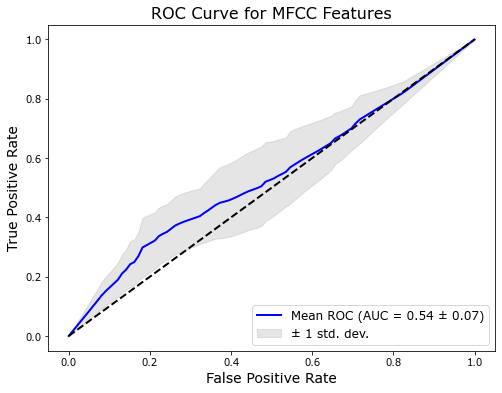

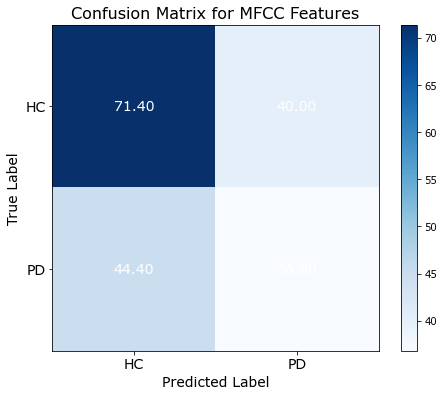

Selected Hyperparameters for Spectrogram:
Fold 1: {'criterion': 'gini', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 13}
Fold 2: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 9, 'min_samples_split': 7}
Fold 3: {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2}
Fold 4: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 18}
Fold 5: {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 5}
Mean Training Time for Spectrogram: 0.6136 seconds
Mean Testing Time for Spectrogram: 0.0034 seconds


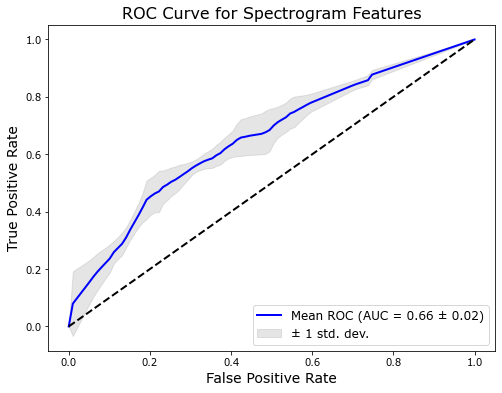

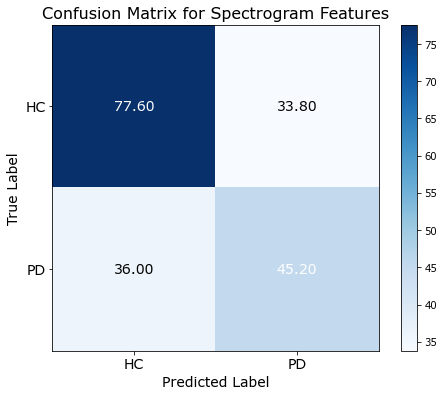

Selected Hyperparameters for Spectral:
Fold 1: {'criterion': 'gini', 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 8}
Fold 2: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 3}
Fold 3: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 18}
Fold 4: {'criterion': 'gini', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 13}
Fold 5: {'criterion': 'gini', 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 15}
Mean Training Time for Spectral: 0.8066 seconds
Mean Testing Time for Spectral: 0.0035 seconds


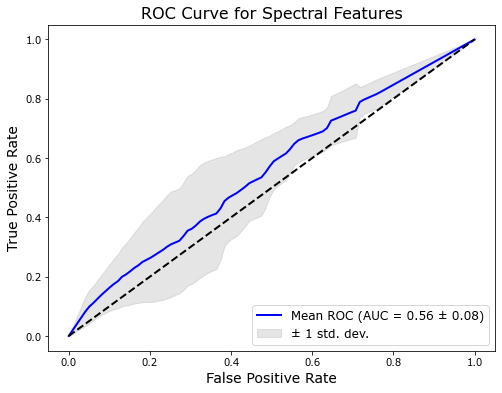

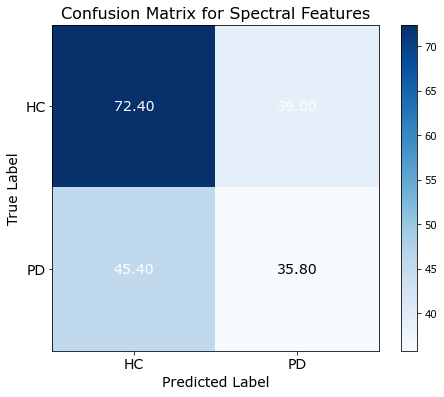

Selected Hyperparameters for Voice_Quality:
Fold 1: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 13}
Fold 2: {'criterion': 'entropy', 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 6, 'min_samples_split': 3}
Fold 3: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 13}
Fold 4: {'criterion': 'entropy', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 5}
Fold 5: {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 8}
Mean Training Time for Voice_Quality: 0.4944 seconds
Mean Testing Time for Voice_Quality: 0.0033 seconds


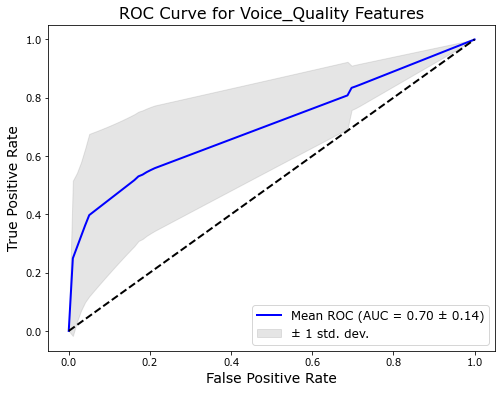

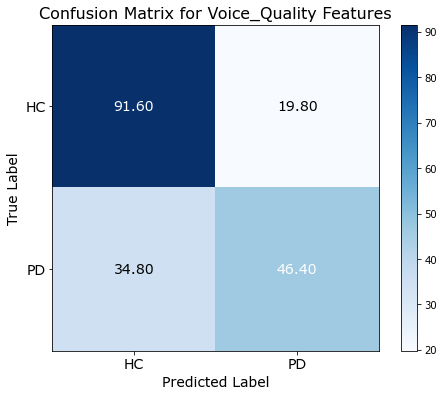

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Hyperparameters for All_Features:
Fold 1: {'criterion': 'entropy', 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 6, 'min_samples_split': 3}
Fold 2: {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 8}
Fold 3: {'criterion': 'entropy', 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 6, 'min_samples_split': 3}
Fold 4: {'criterion': 'entropy', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 3}
Fold 5: {'criterion': 'gini', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 7}
Mean Training Time for All_Features: 1.3745 seconds
Mean Testing Time for All_Features: 0.0036 seconds


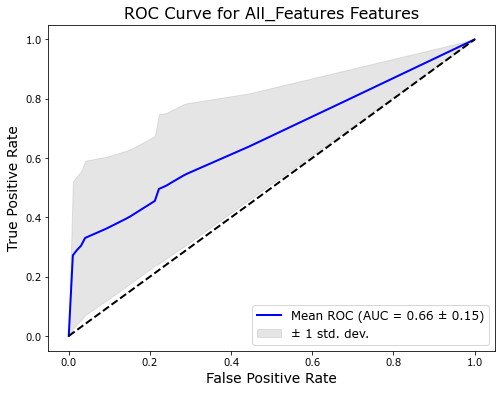

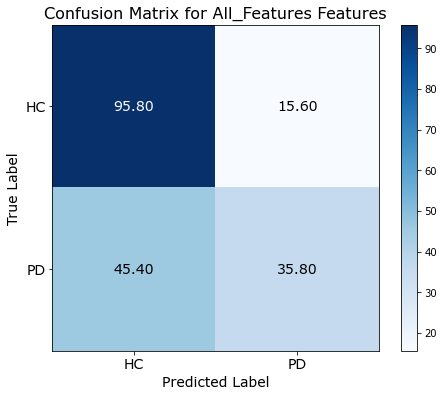

     Feature Set  Mean accuracy  Mean precision  Mean recall   Mean f1  \
0           MFCC       0.562676        0.476110     0.452793  0.461413   
1    Spectrogram       0.637813        0.578423     0.556615  0.563238   
2       Spectral       0.562739        0.484861     0.439115  0.454585   
3  Voice_Quality       0.713299        0.794650     0.572992  0.631829   
4   All_Features       0.679495        0.666798     0.444117  0.497654   

   Mean roc_auc  Mean mcc  Mean log_loss  Mean cohen_kappa  Mean mae  ...  \
0      0.538117  0.095946      10.529096          0.095734  0.437324  ...   
1      0.656991  0.258548       6.386614          0.255697  0.362187  ...   
2      0.555297  0.095647       7.555493          0.092780  0.437261  ...   
3      0.704001  0.441818       9.394513          0.408992  0.286701  ...   
4      0.664937  0.354383      10.473760          0.317444  0.320505  ...   

   Std Dev f1  Std Dev roc_auc  Std Dev mcc  Std Dev log_loss  \
0    0.092643         0.073

In [7]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedGroupKFold, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier  # Replace Random Forest with Decision Tree
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, matthews_corrcoef, log_loss, cohen_kappa_score, mean_absolute_error, roc_curve
)
from scipy.stats import randint

# Load the CSV file with extracted features
csv_output_path = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\SpontaneousDialogue\enhanced_integral_feature_dataset-ii.csv'
data = pd.read_csv(csv_output_path)

# Remove any rows with null values
data.dropna(inplace=True)

# Extract patient ID from file_name
def extract_patient_id(file_name):
    return file_name.split('_')[0]  # Extract the patient ID (e.g., ID00)

# Add a 'group' column based on patient ID
data['group'] = data['file_name'].apply(extract_patient_id)

# Define feature groups based on feature types
feature_groups = {
    'MFCC': ['mfcc_1', 'mfcc_delta_1', 'mfcc_delta2_1', 'mfcc_2', 'mfcc_delta_2', 'mfcc_delta2_2', 
             'mfcc_3', 'mfcc_delta_3', 'mfcc_delta2_3', 'mfcc_4', 'mfcc_delta_4', 'mfcc_delta2_4', 
             'mfcc_5', 'mfcc_delta_5', 'mfcc_delta2_5', 'mfcc_6', 'mfcc_delta_6', 'mfcc_delta2_6', 
             'mfcc_7', 'mfcc_delta_7', 'mfcc_delta2_7', 'mfcc_8', 'mfcc_delta_8', 'mfcc_delta2_8', 
             'mfcc_9', 'mfcc_delta_9', 'mfcc_delta2_9', 'mfcc_10', 'mfcc_delta_10', 'mfcc_delta2_10', 
             'mfcc_11', 'mfcc_delta_11', 'mfcc_delta2_11', 'mfcc_12', 'mfcc_delta_12', 'mfcc_delta2_12', 
             'mfcc_13', 'mfcc_delta_13', 'mfcc_delta2_13', 'entropy', 'kurtosis', 'skewness'],
    'Spectrogram': ['mel_spectrogram', 'chroma_stft', 'entropy', 'kurtosis', 'skewness'],
    'Spectral': ['rmse', 'spectral_contrast', 'spectral_flatness', 'spectral_centroid', 
                 'spectral_bandwidth', 'spectral_rolloff', 'zcr', 'entropy', 'kurtosis', 'skewness'],
    'Voice_Quality': ['jitter_local', 'shimmer_local', 'f0_mean', 'hnr', 'entropy', 'kurtosis', 'skewness']
}

# Add a new feature group that combines all features
feature_groups['All_Features'] = list(set().union(*[features for features in feature_groups.values()]))

# Parameter grid for RandomizedSearchCV (Decision Tree)
param_dist = {
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': randint(2, 20),  # Minimum samples required to split a node
    'min_samples_leaf': randint(1, 10),  # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider at each split
    'criterion': ['gini', 'entropy'],  # Splitting criterion
}

# Store results for comparison
results = []

# Loop through each feature group
for group_name, features in feature_groups.items():
    X = data[features]
    y = data['label']
    groups = data['group']
    
    # Initialize StratifiedGroupKFold
    sgkf = StratifiedGroupKFold(n_splits=5)
    
    # Store metrics for each fold
    fold_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'roc_auc': [],
        'mcc': [],
        'log_loss': [],
        'cohen_kappa': [],
        'mae': [],
        'specificity': [],
        'training_time': [],  # Store training time for each fold
        'testing_time': []   # Store testing time for each fold
    }
    
    # For ROC curve
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    # For confusion matrix
    conf_matrices = []
    
    # For storing selected hyperparameters
    selected_params = []
    
    # Perform cross-validation
    for fold, (train_idx, val_idx) in enumerate(sgkf.split(X, y, groups), 1):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Initialize the classifier with RandomizedSearchCV (Decision Tree)
        clf = DecisionTreeClassifier(random_state=42)  # Use Decision Tree
        random_search = RandomizedSearchCV(
            estimator=clf, param_distributions=param_dist, n_iter=50,
            scoring='accuracy', cv=5, verbose=0, random_state=42, n_jobs=-1
        )
        
        # Measure training time
        start_train_time = time.time()
        random_search.fit(X_train, y_train)
        end_train_time = time.time()
        training_time = end_train_time - start_train_time
        fold_metrics['training_time'].append(training_time)
        
        best_clf = random_search.best_estimator_
        
        # Store selected hyperparameters
        selected_params.append(random_search.best_params_)
        
        # Measure testing time
        start_test_time = time.time()
        y_pred = best_clf.predict(X_val)
        y_pred_proba = best_clf.predict_proba(X_val)[:, 1]
        end_test_time = time.time()
        testing_time = end_test_time - start_test_time
        fold_metrics['testing_time'].append(testing_time)
        
        # Calculate performance metrics
        fold_metrics['accuracy'].append(accuracy_score(y_val, y_pred))
        fold_metrics['precision'].append(precision_score(y_val, y_pred))
        fold_metrics['recall'].append(recall_score(y_val, y_pred))
        fold_metrics['f1'].append(f1_score(y_val, y_pred))
        fold_metrics['roc_auc'].append(roc_auc_score(y_val, y_pred_proba))
        fold_metrics['mcc'].append(matthews_corrcoef(y_val, y_pred))
        fold_metrics['log_loss'].append(log_loss(y_val, y_pred_proba))
        fold_metrics['cohen_kappa'].append(cohen_kappa_score(y_val, y_pred))
        fold_metrics['mae'].append(mean_absolute_error(y_val, y_pred))
        
        # Calculate specificity
        conf_matrix = confusion_matrix(y_val, y_pred)
        specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
        fold_metrics['specificity'].append(specificity)
        
        # Store confusion matrix
        conf_matrices.append(conf_matrix)
        
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        aucs.append(roc_auc_score(y_val, y_pred_proba))
    
    # Calculate mean and std dev of performance metrics
    mean_metrics = {k: np.mean(v) for k, v in fold_metrics.items()}
    std_metrics = {k: np.std(v) for k, v in fold_metrics.items()}
    
    # Store results for this feature group
    results.append({
        'Feature Set': group_name,
        **{f'Mean {k}': v for k, v in mean_metrics.items()},
        **{f'Std Dev {k}': v for k, v in std_metrics.items()},
        'Selected Hyperparameters': selected_params  # Add selected hyperparameters
    })
    
    # Print selected hyperparameters for this feature group
    print(f"Selected Hyperparameters for {group_name}:")
    for fold, params in enumerate(selected_params, 1):
        print(f"Fold {fold}: {params}")
    
    # Print mean training and testing time
    print(f"Mean Training Time for {group_name}: {mean_metrics['training_time']:.4f} seconds")
    print(f"Mean Testing Time for {group_name}: {mean_metrics['testing_time']:.4f} seconds")
    
    # Plot mean ROC curve with std dev
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    
    plt.figure(figsize=(8, 6))
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)
    plt.fill_between(mean_fpr, mean_tpr - np.std(tprs, axis=0), mean_tpr + np.std(tprs, axis=0), color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title(f'ROC Curve for {group_name} Features', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    
    # Plot mean confusion matrix with values
    mean_conf_matrix = np.mean(conf_matrices, axis=0)
    plt.figure(figsize=(8, 6))
    plt.imshow(mean_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {group_name} Features', fontsize=16)
    plt.colorbar()
    plt.xticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.yticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)

    # Add text annotations for the confusion matrix values
    thresh = mean_conf_matrix.max() / 2.  # Threshold for text color
    for i in range(mean_conf_matrix.shape[0]):
        for j in range(mean_conf_matrix.shape[1]):
            plt.text(j, i, f"{mean_conf_matrix[i, j]:.2f}",
                     horizontalalignment="center",
                     verticalalignment="center",
                     color="white" if mean_conf_matrix[i, j] > thresh else "black",
                     fontsize=14)

    plt.show()

# Convert results to DataFrame for easier comparison
results_df = pd.DataFrame(results)
print(results_df)

# Optionally, save the results to a CSV file
results_df.to_csv('d2feature_comparison_results_with_DII_dt.csv', index=False)

In [8]:
import pandas as pd

# Define the path to the CSV file
csv_output_path = r'd2feature_comparison_results_with_DII_dt.csv'

# Load the data
data = pd.read_csv(csv_output_path)

data

Feature Set  Mean accuracy  Mean precision  Mean recall   Mean f1  \
0           MFCC       0.562676        0.476110     0.452793  0.461413   
1    Spectrogram       0.637813        0.578423     0.556615  0.563238   
2       Spectral       0.562739        0.484861     0.439115  0.454585   
3  Voice_Quality       0.713299        0.794650     0.572992  0.631829   
4   All_Features       0.679495        0.666798     0.444117  0.497654   

   Mean roc_auc  Mean mcc  Mean log_loss  Mean cohen_kappa  Mean mae  ...  \
0      0.538117  0.095946      10.529096          0.095734  0.437324  ...   
1      0.656991  0.258548       6.386614          0.255697  0.362187  ...   
2      0.555297  0.095647       7.555493          0.092780  0.437261  ...   
3      0.704001  0.441818       9.394513          0.408992  0.286701  ...   
4      0.664937  0.354383      10.473760          0.317444  0.320505  ...   

   Std Dev f1  Std Dev roc_auc  Std Dev mcc  Std Dev log_loss  \
0    0.092643         0.073017     0.122634          4.670595   
1    0.015518         0.019049     0.022133          2.391208   
2    0.091165         0.076676     0.143883          2.000147   
3    0.142748         0.139967     0.272059          5.370791   
4    0.273986         0.149294     0.304158          6.265766   

   Std Dev cohen_kappa  Std Dev mae  Std Dev specificity  \
0             0.121292     0.054695             0.058546   
1             0.018432     0.013696             0.065167   
2             0.142647     0.070836             0.099669   
3             0.265136     0.143921             0.262137   
4             0.283923     0.143833             0.273308   

   Std Dev training_time  Std Dev testing_time  \
0               0.052713              0.000492   
1               0.010744              0.001242   
2               0.015764              0.000424   
3               0.020535              0.001053   
4               0.056608              0.000790   

                            Selected Hyperparameters  
0  [{'criterion': 'gini', 'max_depth': 10, 'max_f...  
1  [{'criterion': 'gini', 'max_depth': 20, 'max_f...  
2  [{'criterion': 'gini', 'max_depth': 30, 'max_f...  
3  [{'criterion': 'entropy', 'max_depth': 10, 'ma...  
4  [{'criterion': 'entropy', 'max_depth': 30, 'ma...  

[5 rows x 26 columns]

Selected Hyperparameters for MFCC:
Fold 1: {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 183}
Fold 2: {'algorithm': 'SAMME', 'learning_rate': 0.01, 'n_estimators': 152}
Fold 3: {'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 124}
Fold 4: {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 153}
Fold 5: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 180}
Mean Training Time for MFCC: 92.4095 seconds
Mean Testing Time for MFCC: 0.0455 seconds


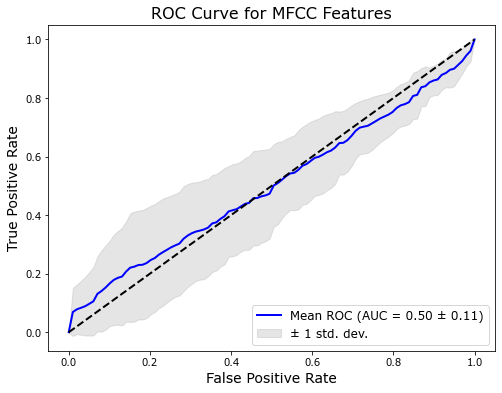

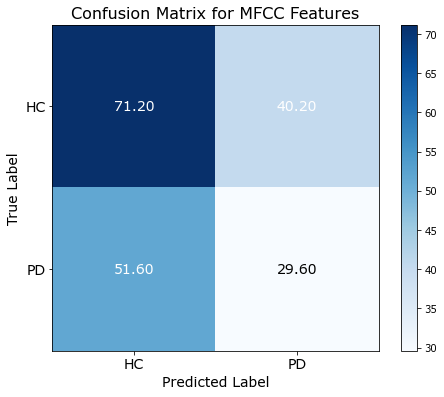

Selected Hyperparameters for Spectrogram:
Fold 1: {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 153}
Fold 2: {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 153}
Fold 3: {'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 57}
Fold 4: {'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 57}
Fold 5: {'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 111}
Mean Training Time for Spectrogram: 42.9143 seconds
Mean Testing Time for Spectrogram: 0.1287 seconds


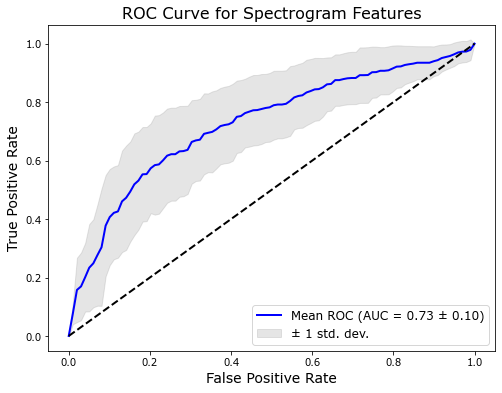

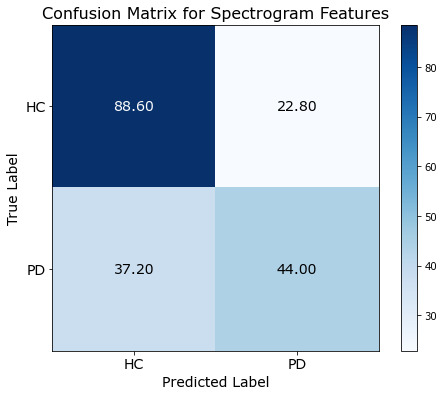

Selected Hyperparameters for Spectral:
Fold 1: {'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 188}
Fold 2: {'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 180}
Fold 3: {'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 160}
Fold 4: {'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 160}
Fold 5: {'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 63}
Mean Training Time for Spectral: 73.5804 seconds
Mean Testing Time for Spectral: 0.2250 seconds


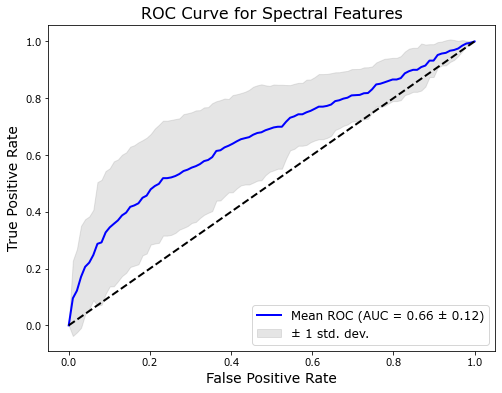

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Hyperparameters for Voice_Quality:
Fold 1: {'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 166}
Fold 2: {'algorithm': 'SAMME', 'learning_rate': 0.1, 'n_estimators': 64}
Fold 3: {'algorithm': 'SAMME', 'learning_rate': 0.01, 'n_estimators': 152}
Fold 4: {'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 63}
Fold 5: {'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 113}
Mean Training Time for Voice_Quality: 49.2595 seconds
Mean Testing Time for Voice_Quality: 0.1437 seconds


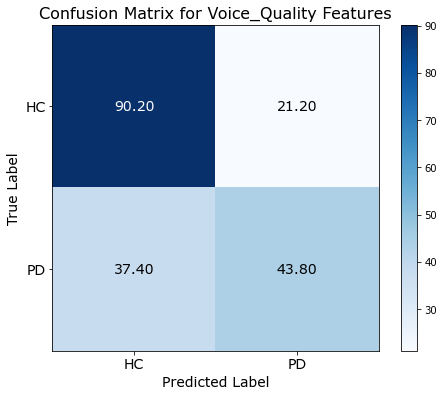

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Selected Hyperparameters for All_Features:
Fold 1: {'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 124}
Fold 2: {'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 87}
Fold 3: {'algorithm': 'SAMME', 'learning_rate': 0.01, 'n_estimators': 152}
Fold 4: {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 53}
Fold 5: {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 153}
Mean Training Time for All_Features: 225.7739 seconds
Mean Testing Time for All_Features: 0.2488 seconds


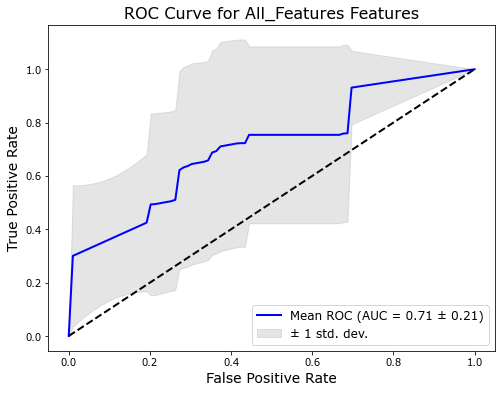

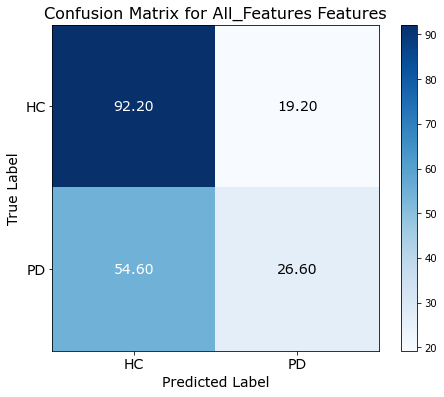

     Feature Set  Mean accuracy  Mean precision  Mean recall   Mean f1  \
0           MFCC       0.524777        0.504246     0.363961  0.390981   
1    Spectrogram       0.687945        0.655923     0.539048  0.584704   
2       Spectral       0.651531        0.601244     0.531720  0.562424   
3  Voice_Quality       0.694265        0.610737     0.540072  0.535817   
4   All_Features       0.615374        0.498971     0.324469  0.376837   

   Mean roc_auc  Mean mcc  Mean log_loss  Mean cohen_kappa  Mean mae  ...  \
0      0.501940  0.033629       0.701576          0.013984  0.475223  ...   
1      0.725466  0.349681       0.679391          0.342375  0.312055  ...   
2      0.661634  0.277923       0.684734          0.275233  0.348469  ...   
3      0.698918  0.375529       0.608591          0.354120  0.305735  ...   
4      0.710593  0.179086       0.894890          0.158260  0.384626  ...   

   Std Dev f1  Std Dev roc_auc  Std Dev mcc  Std Dev log_loss  \
0    0.016465         0.113

In [9]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedGroupKFold, RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier  # Replace Decision Tree with AdaBoost
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, matthews_corrcoef, log_loss, cohen_kappa_score, mean_absolute_error, roc_curve
)
from scipy.stats import randint

# Load the CSV file with extracted features
csv_output_path = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\SpontaneousDialogue\enhanced_integral_feature_dataset-ii.csv'

data = pd.read_csv(csv_output_path)

# Remove any rows with null values
data.dropna(inplace=True)

# Extract patient ID from file_name
def extract_patient_id(file_name):
    return file_name.split('_')[0]  # Extract the patient ID (e.g., ID00)

# Add a 'group' column based on patient ID
data['group'] = data['file_name'].apply(extract_patient_id)

# Define feature groups based on feature types
feature_groups = {
    'MFCC': ['mfcc_1', 'mfcc_delta_1', 'mfcc_delta2_1', 'mfcc_2', 'mfcc_delta_2', 'mfcc_delta2_2', 
             'mfcc_3', 'mfcc_delta_3', 'mfcc_delta2_3', 'mfcc_4', 'mfcc_delta_4', 'mfcc_delta2_4', 
             'mfcc_5', 'mfcc_delta_5', 'mfcc_delta2_5', 'mfcc_6', 'mfcc_delta_6', 'mfcc_delta2_6', 
             'mfcc_7', 'mfcc_delta_7', 'mfcc_delta2_7', 'mfcc_8', 'mfcc_delta_8', 'mfcc_delta2_8', 
             'mfcc_9', 'mfcc_delta_9', 'mfcc_delta2_9', 'mfcc_10', 'mfcc_delta_10', 'mfcc_delta2_10', 
             'mfcc_11', 'mfcc_delta_11', 'mfcc_delta2_11', 'mfcc_12', 'mfcc_delta_12', 'mfcc_delta2_12', 
             'mfcc_13', 'mfcc_delta_13', 'mfcc_delta2_13', 'entropy', 'kurtosis', 'skewness'],
    'Spectrogram': ['mel_spectrogram', 'chroma_stft', 'entropy', 'kurtosis', 'skewness'],
    'Spectral': ['rmse', 'spectral_contrast', 'spectral_flatness', 'spectral_centroid', 
                 'spectral_bandwidth', 'spectral_rolloff', 'zcr', 'entropy', 'kurtosis', 'skewness'],
    'Voice_Quality': ['jitter_local', 'shimmer_local', 'f0_mean', 'hnr', 'entropy', 'kurtosis', 'skewness']
}

# Add a new feature group that combines all features
feature_groups['All_Features'] = list(set().union(*[features for features in feature_groups.values()]))

# Parameter grid for RandomizedSearchCV (AdaBoost)
param_dist = {
    'n_estimators': randint(50, 200),  # Number of boosting stages
    'learning_rate': [0.01, 0.1, 0.5, 1.0],  # Learning rate
    'algorithm': ['SAMME', 'SAMME.R'],  # Boosting algorithm
}

# Store results for comparison
results = []

# Loop through each feature group
for group_name, features in feature_groups.items():
    X = data[features]
    y = data['label']
    groups = data['group']
    
    # Initialize StratifiedGroupKFold
    sgkf = StratifiedGroupKFold(n_splits=5)
    
    # Store metrics for each fold
    fold_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'roc_auc': [],
        'mcc': [],
        'log_loss': [],
        'cohen_kappa': [],
        'mae': [],
        'specificity': [],
        'training_time': [],  # Store training time for each fold
        'testing_time': []   # Store testing time for each fold
    }
    
    # For ROC curve
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    # For confusion matrix
    conf_matrices = []
    
    # For storing selected hyperparameters
    selected_params = []
    
    # Perform cross-validation
    for fold, (train_idx, val_idx) in enumerate(sgkf.split(X, y, groups), 1):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Initialize the classifier with RandomizedSearchCV (AdaBoost)
        clf = AdaBoostClassifier(random_state=42)  # Use AdaBoost
        random_search = RandomizedSearchCV(
            estimator=clf, param_distributions=param_dist, n_iter=50,
            scoring='accuracy', cv=5, verbose=0, random_state=42, n_jobs=-1
        )
        
        # Measure training time
        start_train_time = time.time()
        random_search.fit(X_train, y_train)
        end_train_time = time.time()
        training_time = end_train_time - start_train_time
        fold_metrics['training_time'].append(training_time)
        
        best_clf = random_search.best_estimator_
        
        # Store selected hyperparameters
        selected_params.append(random_search.best_params_)
        
        # Measure testing time
        start_test_time = time.time()
        y_pred = best_clf.predict(X_val)
        y_pred_proba = best_clf.predict_proba(X_val)[:, 1]
        end_test_time = time.time()
        testing_time = end_test_time - start_test_time
        fold_metrics['testing_time'].append(testing_time)
        
        # Calculate performance metrics
        fold_metrics['accuracy'].append(accuracy_score(y_val, y_pred))
        fold_metrics['precision'].append(precision_score(y_val, y_pred))
        fold_metrics['recall'].append(recall_score(y_val, y_pred))
        fold_metrics['f1'].append(f1_score(y_val, y_pred))
        fold_metrics['roc_auc'].append(roc_auc_score(y_val, y_pred_proba))
        fold_metrics['mcc'].append(matthews_corrcoef(y_val, y_pred))
        fold_metrics['log_loss'].append(log_loss(y_val, y_pred_proba))
        fold_metrics['cohen_kappa'].append(cohen_kappa_score(y_val, y_pred))
        fold_metrics['mae'].append(mean_absolute_error(y_val, y_pred))
        
        # Calculate specificity
        conf_matrix = confusion_matrix(y_val, y_pred)
        specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
        fold_metrics['specificity'].append(specificity)
        
        # Store confusion matrix
        conf_matrices.append(conf_matrix)
        
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        aucs.append(roc_auc_score(y_val, y_pred_proba))
    
    # Calculate mean and std dev of performance metrics
    mean_metrics = {k: np.mean(v) for k, v in fold_metrics.items()}
    std_metrics = {k: np.std(v) for k, v in fold_metrics.items()}
    
    # Store results for this feature group
    results.append({
        'Feature Set': group_name,
        **{f'Mean {k}': v for k, v in mean_metrics.items()},
        **{f'Std Dev {k}': v for k, v in std_metrics.items()},
        'Selected Hyperparameters': selected_params  # Add selected hyperparameters
    })
    
    # Print selected hyperparameters for this feature group
    print(f"Selected Hyperparameters for {group_name}:")
    for fold, params in enumerate(selected_params, 1):
        print(f"Fold {fold}: {params}")
    
    # Print mean training and testing time
    print(f"Mean Training Time for {group_name}: {mean_metrics['training_time']:.4f} seconds")
    print(f"Mean Testing Time for {group_name}: {mean_metrics['testing_time']:.4f} seconds")
    
    # Plot mean ROC curve with std dev
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    
    plt.figure(figsize=(8, 6))
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)
    plt.fill_between(mean_fpr, mean_tpr - np.std(tprs, axis=0), mean_tpr + np.std(tprs, axis=0), color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title(f'ROC Curve for {group_name} Features', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    
    # Plot mean confusion matrix with values
    mean_conf_matrix = np.mean(conf_matrices, axis=0)
    plt.figure(figsize=(8, 6))
    plt.imshow(mean_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {group_name} Features', fontsize=16)
    plt.colorbar()
    plt.xticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.yticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)

    # Add text annotations for the confusion matrix values
    thresh = mean_conf_matrix.max() / 2.  # Threshold for text color
    for i in range(mean_conf_matrix.shape[0]):
        for j in range(mean_conf_matrix.shape[1]):
            plt.text(j, i, f"{mean_conf_matrix[i, j]:.2f}",
                     horizontalalignment="center",
                     verticalalignment="center",
                     color="white" if mean_conf_matrix[i, j] > thresh else "black",
                     fontsize=14)

    plt.show()

# Convert results to DataFrame for easier comparison
results_df = pd.DataFrame(results)
print(results_df)

# Optionally, save the results to a CSV file
results_df.to_csv('d2feature_comparison_results_with_DII_adaboost.csv', index=False)

In [10]:
import pandas as pd

# Define the path to the CSV file
csv_output_path = r'd2feature_comparison_results_with_DII_adaboost.csv'

# Load the data
data = pd.read_csv(csv_output_path)

data

Feature Set  Mean accuracy  Mean precision  Mean recall   Mean f1  \
0           MFCC       0.524777        0.504246     0.363961  0.390981   
1    Spectrogram       0.687945        0.655923     0.539048  0.584704   
2       Spectral       0.651531        0.601244     0.531720  0.562424   
3  Voice_Quality       0.694265        0.610737     0.540072  0.535817   
4   All_Features       0.615374        0.498971     0.324469  0.376837   

   Mean roc_auc  Mean mcc  Mean log_loss  Mean cohen_kappa  Mean mae  ...  \
0      0.501940  0.033629       0.701576          0.013984  0.475223  ...   
1      0.725466  0.349681       0.679391          0.342375  0.312055  ...   
2      0.661634  0.277923       0.684734          0.275233  0.348469  ...   
3      0.698918  0.375529       0.608591          0.354120  0.305735  ...   
4      0.710593  0.179086       0.894890          0.158260  0.384626  ...   

   Std Dev f1  Std Dev roc_auc  Std Dev mcc  Std Dev log_loss  \
0    0.016465         0.113534     0.176856          0.017555   
1    0.123965         0.101792     0.165400          0.010230   
2    0.129962         0.124997     0.221190          0.007408   
3    0.321872         0.255847     0.370236          0.112232   
4    0.261410         0.210609     0.316378          0.555290   

   Std Dev cohen_kappa  Std Dev mae  Std Dev specificity  \
0             0.146403     0.090640             0.213308   
1             0.166763     0.075536             0.071085   
2             0.220485     0.107382             0.106694   
3             0.366880     0.178403             0.270344   
4             0.296503     0.135640             0.166945   

   Std Dev training_time  Std Dev testing_time  \
0              16.410940              0.013830   
1              11.409832              0.046327   
2               2.914598              0.134278   
3               1.023899              0.070821   
4               6.175522              0.142442   

                            Selected Hyperparameters  
0  [{'algorithm': 'SAMME.R', 'learning_rate': 0.1...  
1  [{'algorithm': 'SAMME.R', 'learning_rate': 0.1...  
2  [{'algorithm': 'SAMME.R', 'learning_rate': 0.5...  
3  [{'algorithm': 'SAMME', 'learning_rate': 1.0, ...  
4  [{'algorithm': 'SAMME.R', 'learning_rate': 0.5...  

[5 rows x 26 columns]

Mean Training Time for MFCC: 472.8233 seconds
Mean Testing Time for MFCC: 0.3820 seconds


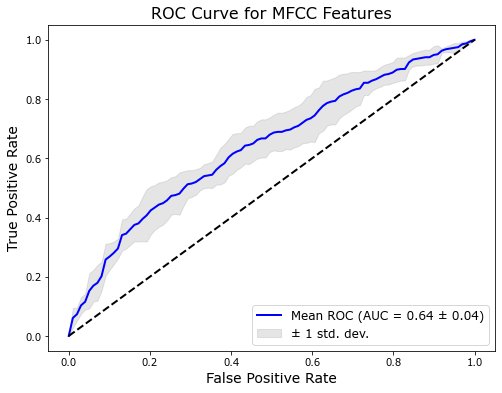

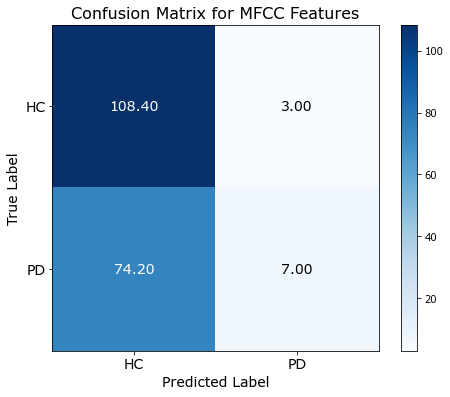

Mean Training Time for Spectrogram: 317.5115 seconds
Mean Testing Time for Spectrogram: 0.3003 seconds


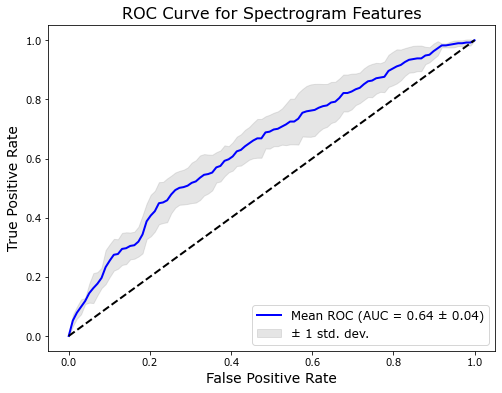

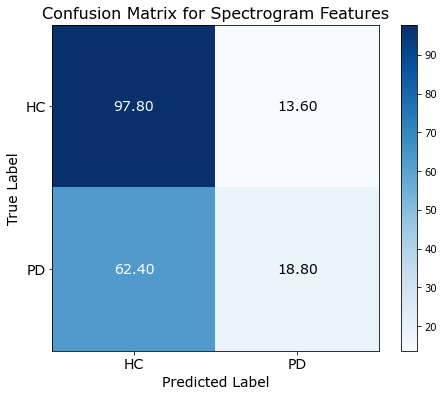

Mean Training Time for Spectral: 346.4252 seconds
Mean Testing Time for Spectral: 0.3235 seconds


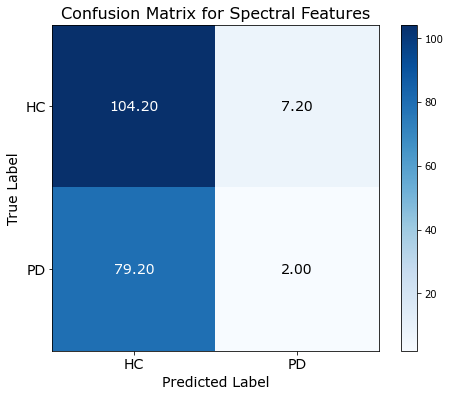

Mean Training Time for Voice_Quality: 283.5687 seconds
Mean Testing Time for Voice_Quality: 0.2535 seconds


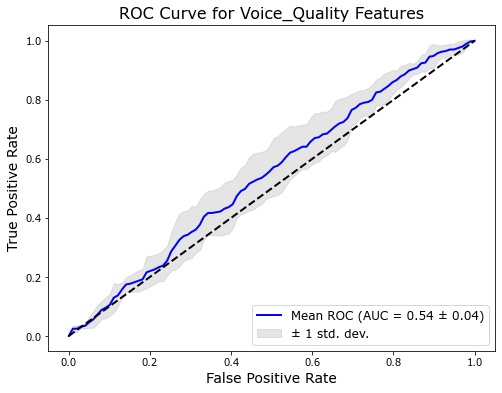

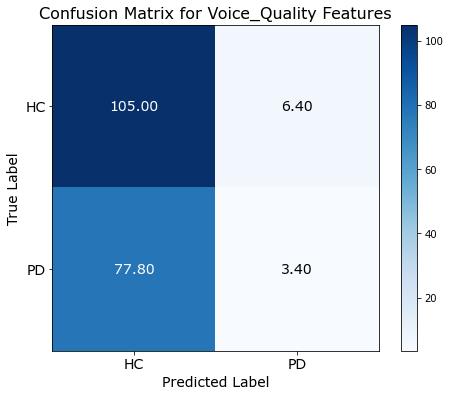

Mean Training Time for All_Features: 822.8757 seconds
Mean Testing Time for All_Features: 0.3437 seconds


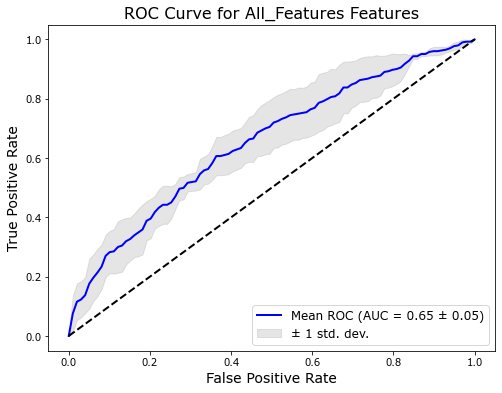

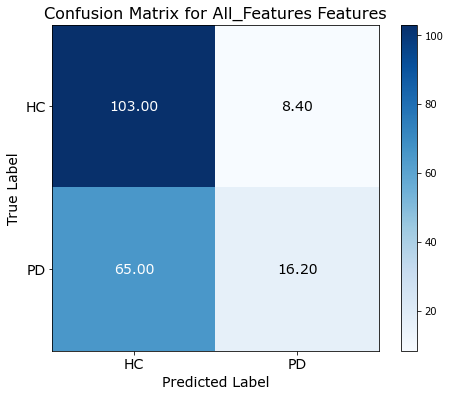

     Feature Set  Mean accuracy  Mean precision  Mean recall   Mean f1  \
0           MFCC       0.599071        0.731111     0.087123  0.150624   
1    Spectrogram       0.604638        0.629128     0.234680  0.316343   
2       Spectral       0.550279        0.069610     0.025816  0.036444   
3  Voice_Quality       0.561926        0.165116     0.043771  0.060460   
4   All_Features       0.618590        0.757642     0.202533  0.287685   

   Mean roc_auc  Mean mcc  Mean log_loss  Mean cohen_kappa  Mean mae  ...  \
0      0.641617  0.135259       0.663949          0.067959  0.400929  ...   
1      0.643116  0.159845       0.657590          0.119986  0.395362  ...   
2      0.496884 -0.065803       0.688044         -0.045260  0.449721  ...   
3      0.543366 -0.015116       0.681752         -0.016731  0.438074  ...   
4      0.653203  0.208699       0.658525          0.138426  0.381410  ...   

   Std Dev recall  Std Dev f1  Std Dev roc_auc  Std Dev mcc  Std Dev log_loss  \
0        0.

In [19]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedGroupKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, matthews_corrcoef, log_loss, cohen_kappa_score, mean_absolute_error, roc_curve
)
from scipy.stats import randint, uniform
from sklearn.preprocessing import StandardScaler

# Load the CSV file with extracted features
csv_output_path = r'F:\PhD 2021-2024\Phd-IV Year\VIII\Voice MDVR\DATASET V\SpontaneousDialogue\enhanced_integral_feature_dataset-ii.csv'
data = pd.read_csv(csv_output_path)

# Remove any rows with null values
data.dropna(inplace=True)

# Extract patient ID from file_name
def extract_patient_id(file_name):
    return file_name.split('_')[0]  # Extract the patient ID (e.g., ID00)

# Add a 'group' column based on patient ID
data['group'] = data['file_name'].apply(extract_patient_id)

# Normalize features by speaker (z-score normalization)
def normalize_by_speaker(data, features):
    normalized_data = data.copy()
    scaler = StandardScaler()
    for speaker in normalized_data['group'].unique():
        speaker_mask = normalized_data['group'] == speaker
        normalized_data.loc[speaker_mask, features] = scaler.fit_transform(normalized_data.loc[speaker_mask, features])
    return normalized_data

# Define feature groups based on feature types
feature_groups = {
    'MFCC': ['mfcc_1', 'mfcc_delta_1', 'mfcc_delta2_1', 'mfcc_2', 'mfcc_delta_2', 'mfcc_delta2_2', 
             'mfcc_3', 'mfcc_delta_3', 'mfcc_delta2_3', 'mfcc_4', 'mfcc_delta_4', 'mfcc_delta2_4', 
             'mfcc_5', 'mfcc_delta_5', 'mfcc_delta2_5', 'mfcc_6', 'mfcc_delta_6', 'mfcc_delta2_6', 
             'mfcc_7', 'mfcc_delta_7', 'mfcc_delta2_7', 'mfcc_8', 'mfcc_delta_8', 'mfcc_delta2_8', 
             'mfcc_9', 'mfcc_delta_9', 'mfcc_delta2_9', 'mfcc_10', 'mfcc_delta_10', 'mfcc_delta2_10', 
             'mfcc_11', 'mfcc_delta_11', 'mfcc_delta2_11', 'mfcc_12', 'mfcc_delta_12', 'mfcc_delta2_12', 
             'mfcc_13', 'mfcc_delta_13', 'mfcc_delta2_13', 'entropy', 'kurtosis', 'skewness'],
    'Spectrogram': ['mel_spectrogram', 'chroma_stft', 'entropy', 'kurtosis', 'skewness'],
    'Spectral': ['rmse', 'spectral_contrast', 'spectral_flatness', 'spectral_centroid', 
                 'spectral_bandwidth', 'spectral_rolloff', 'zcr', 'entropy', 'kurtosis', 'skewness'],
    'Voice_Quality': ['jitter_local', 'shimmer_local', 'f0_mean', 'hnr', 'entropy', 'kurtosis', 'skewness']
}

# Add a new feature group that combines all features
feature_groups['All_Features'] = list(set().union(*[features for features in feature_groups.values()]))

# Normalize features by speaker
for group_name, features in feature_groups.items():
    data = normalize_by_speaker(data, features)
    

# Hyperparameter grids for RandomizedSearchCV for each base model
param_dist_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_dist_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

param_dist_adaboost = {
    'n_estimators': [50, 100, 200],
    'learning_rate': uniform(0.01, 0.3)
}

# Define the base classifiers for the StackingClassifier (RandomForest, KNN, AdaBoost)
base_learners = [
    ('rf', RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_dist_rf, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)),
    ('knn', RandomizedSearchCV(KNeighborsClassifier(), param_distributions=param_dist_knn, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)),
    ('adaboost', RandomizedSearchCV(AdaBoostClassifier(random_state=42), param_distributions=param_dist_adaboost, n_iter=10, cv=5, scoring='accuracy', random_state=42, n_jobs=-1))
]

# Define the meta-classifier (stacking)
meta_classifier = LogisticRegression(solver='liblinear', random_state=42)

# Initialize the StackingClassifier
stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=meta_classifier, cv=5, n_jobs=-1)

# Store results for comparison
results = []

# Loop through each feature group
for group_name, features in feature_groups.items():
    X = data[features]
    y = data['label']
    groups = data['group']
    
    # Initialize StratifiedGroupKFold
    sgkf = StratifiedGroupKFold(n_splits=5)
    
    # Store metrics for each fold
    fold_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'roc_auc': [],
        'mcc': [],
        'log_loss': [],
        'cohen_kappa': [],
        'mae': [],
        'specificity': [],
        'training_time': [],  # Store training time for each fold
        'testing_time': []   # Store testing time for each fold
    }
    
    # For ROC curve
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    # For confusion matrix
    conf_matrices = []
    
    # For storing selected hyperparameters
    selected_params = []
    
    # Perform cross-validation
    for fold, (train_idx, val_idx) in enumerate(sgkf.split(X, y, groups), 1):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Measure training time
        start_train_time = time.time()
        stacking_clf.fit(X_train, y_train)
        end_train_time = time.time()
        training_time = end_train_time - start_train_time
        fold_metrics['training_time'].append(training_time)
        
        # Measure testing time
        start_test_time = time.time()
        y_pred = stacking_clf.predict(X_val)
        y_pred_proba = stacking_clf.predict_proba(X_val)[:, 1]
        end_test_time = time.time()
        testing_time = end_test_time - start_test_time
        fold_metrics['testing_time'].append(testing_time)
        
        # Calculate performance metrics
        fold_metrics['accuracy'].append(accuracy_score(y_val, y_pred))
        fold_metrics['precision'].append(precision_score(y_val, y_pred))
        fold_metrics['recall'].append(recall_score(y_val, y_pred))
        fold_metrics['f1'].append(f1_score(y_val, y_pred))
        fold_metrics['roc_auc'].append(roc_auc_score(y_val, y_pred_proba))
        fold_metrics['mcc'].append(matthews_corrcoef(y_val, y_pred))
        fold_metrics['log_loss'].append(log_loss(y_val, y_pred_proba))
        fold_metrics['cohen_kappa'].append(cohen_kappa_score(y_val, y_pred))
        fold_metrics['mae'].append(mean_absolute_error(y_val, y_pred))
        
        # Calculate specificity
        conf_matrix = confusion_matrix(y_val, y_pred)
        specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
        fold_metrics['specificity'].append(specificity)
        
        # Store confusion matrix
        conf_matrices.append(conf_matrix)
        
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        aucs.append(roc_auc_score(y_val, y_pred_proba))
    
    # Calculate mean and std dev of performance metrics
    mean_metrics = {k: np.mean(v) for k, v in fold_metrics.items()}
    std_metrics = {k: np.std(v) for k, v in fold_metrics.items()}
    
    # Store results for this feature group
    results.append({
        'Feature Set': group_name,
        **{f'Mean {k}': v for k, v in mean_metrics.items()},
        **{f'Std Dev {k}': v for k, v in std_metrics.items()},
    })
    
    # Print mean training and testing time
    print(f"Mean Training Time for {group_name}: {mean_metrics['training_time']:.4f} seconds")
    print(f"Mean Testing Time for {group_name}: {mean_metrics['testing_time']:.4f} seconds")
    
    # Plot mean ROC curve with std dev
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    
    plt.figure(figsize=(8, 6))
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)
    plt.fill_between(mean_fpr, mean_tpr - np.std(tprs, axis=0), mean_tpr + np.std(tprs, axis=0), color='grey', alpha=0.2, label='± 1 std. dev.')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title(f'ROC Curve for {group_name} Features', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    
    # Plot mean confusion matrix with values
    mean_conf_matrix = np.mean(conf_matrices, axis=0)
    plt.figure(figsize=(8, 6))
    plt.imshow(mean_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {group_name} Features', fontsize=16)
    plt.colorbar()
    plt.xticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.yticks([0, 1], ['HC', 'PD'], fontsize=14)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)

    # Add text annotations for the confusion matrix values
    thresh = mean_conf_matrix.max() / 2.  # Threshold for text color
    for i in range(mean_conf_matrix.shape[0]):
        for j in range(mean_conf_matrix.shape[1]):
            plt.text(j, i, f"{mean_conf_matrix[i, j]:.2f}",
                     horizontalalignment="center",
                     verticalalignment="center",
                     color="white" if mean_conf_matrix[i, j] > thresh else "black",
                     fontsize=14)

    plt.show()

# Convert results to DataFrame for easier comparison
results_df = pd.DataFrame(results)
print(results_df)

# Optionally, save the results to a CSV file
results_df.to_csv('d2feature_comparison_results_with_DII_stacking.csv', index=False)

In [20]:
import pandas as pd

# Define the path to the CSV file
csv_output_path = r'd2feature_comparison_results_with_DII_stacking.csv'

# Load the data
data = pd.read_csv(csv_output_path)

data

Feature Set  Mean accuracy  Mean precision  Mean recall   Mean f1  \
0           MFCC       0.599071        0.731111     0.087123  0.150624   
1    Spectrogram       0.604638        0.629128     0.234680  0.316343   
2       Spectral       0.550279        0.069610     0.025816  0.036444   
3  Voice_Quality       0.561926        0.165116     0.043771  0.060460   
4   All_Features       0.618590        0.757642     0.202533  0.287685   

   Mean roc_auc  Mean mcc  Mean log_loss  Mean cohen_kappa  Mean mae  ...  \
0      0.641617  0.135259       0.663949          0.067959  0.400929  ...   
1      0.643116  0.159845       0.657590          0.119986  0.395362  ...   
2      0.496884 -0.065803       0.688044         -0.045260  0.449721  ...   
3      0.543366 -0.015116       0.681752         -0.016731  0.438074  ...   
4      0.653203  0.208699       0.658525          0.138426  0.381410  ...   

   Std Dev recall  Std Dev f1  Std Dev roc_auc  Std Dev mcc  Std Dev log_loss  \
0        0.043668    0.066984         0.036510     0.046702          0.002923   
1        0.119621    0.094416         0.040444     0.046125          0.010445   
2        0.045778    0.062691         0.096394     0.080681          0.014763   
3        0.070498    0.090470         0.042663     0.045781          0.006892   
4        0.124181    0.118642         0.050088     0.066028          0.007939   

   Std Dev cohen_kappa  Std Dev mae  Std Dev specificity  \
0             0.028793     0.012776             0.025603   
1             0.036676     0.026513             0.117126   
2             0.057373     0.038968             0.094968   
3             0.039433     0.032180             0.106226   
4             0.046154     0.021091             0.100518   

   Std Dev training_time  Std Dev testing_time  
0               7.077668              0.164905  
1              10.562432              0.224860  
2              11.596375              0.182163  
3               5.654084              0.124284  
4             761.553531              0.135435  

[5 rows x 25 columns]